In [1]:
from diffusers import DiTPipeline, DPMSolverMultistepScheduler
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
# os.environ["HF_ENDPOINT"]="https://hf-mirror.com"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
%load_ext autoreload
%autoreload 2
pipe = DiTPipeline.from_pretrained("facebook/DiT-XL-2-512", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
from alter_attention_processor import AttnProcessor, attn_probs_dict, hidden_states_dict, window_hidden_states_dict

In [3]:
for blocki,block in enumerate(pipe.transformer.transformer_blocks):
    block.attn1.processor=AttnProcessor()
    block.attn1.processor.name=f"block{blocki}"
    attn_probs_dict[block.attn1.processor.name] = []
    hidden_states_dict[block.attn1.processor.name] = []
    window_hidden_states_dict[block.attn1.processor.name] = []
    block.attn1.processor.use_head_share = False

name_list = []
for blocki,block in enumerate(pipe.transformer.transformer_blocks):
    name_list.append(block.attn1.processor.name)

  0%|          | 0/50 [00:00<?, ?it/s]

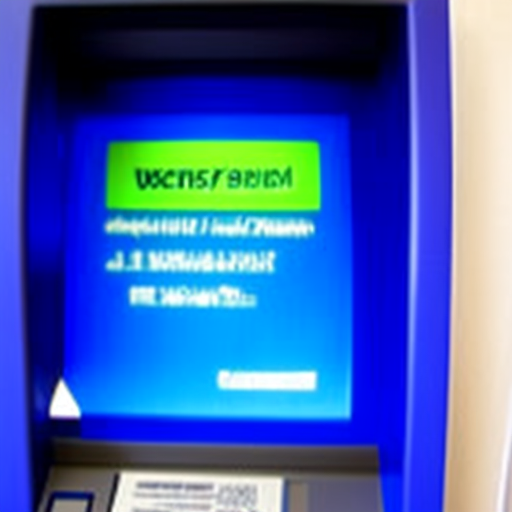

In [4]:
words = ["ATM"]
class_ids = pipe.get_label_ids(words)
generator = torch.manual_seed(34)
output = pipe(class_labels=class_ids, num_inference_steps=50, generator=generator)
image = output.images[0]
image

In [5]:
attention_probs = attn_probs_dict['block27'][-1]
attention_probs.shape

torch.Size([32, 1024, 1024])

/mnt/public/hanling/DiT_env/lib/python3.11/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


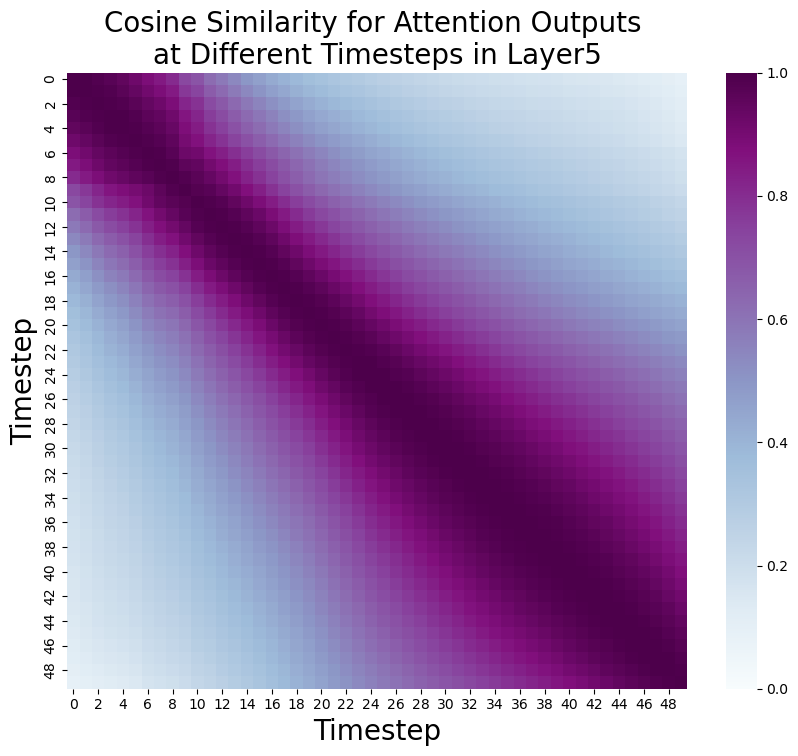

/mnt/public/hanling/DiT_env/lib/python3.11/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


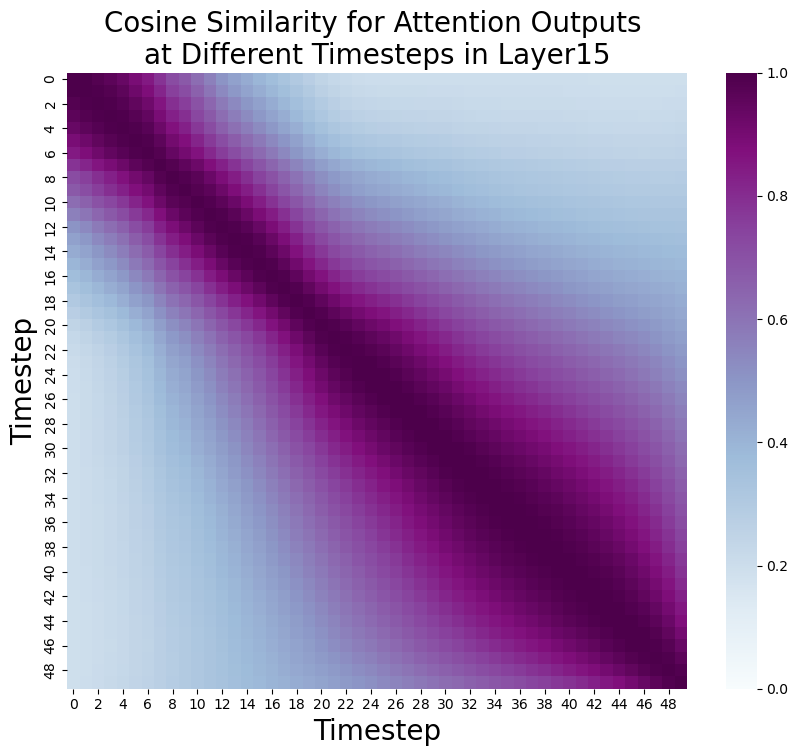

/mnt/public/hanling/DiT_env/lib/python3.11/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


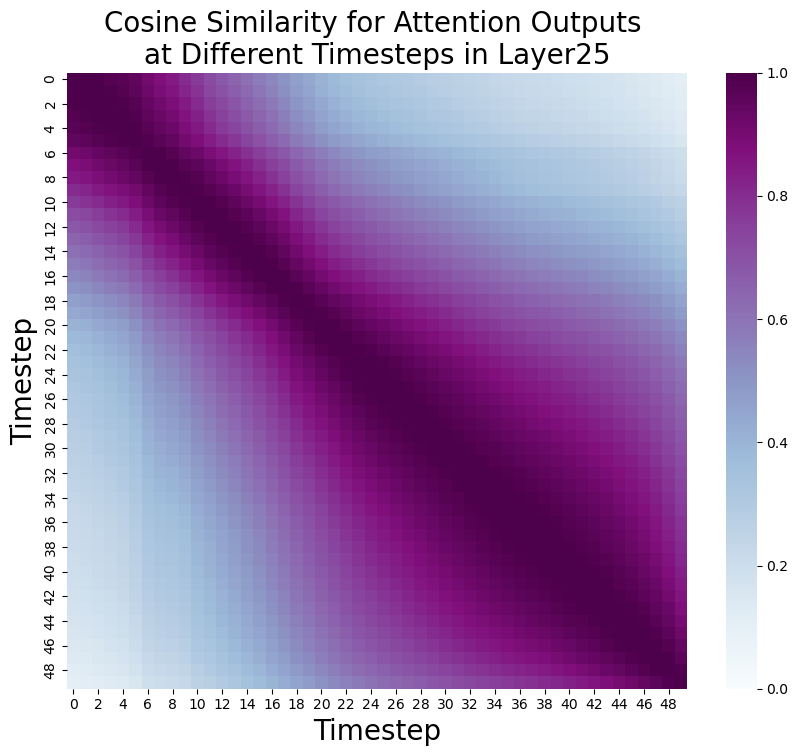

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
if True:
    layer_i =26
    for layer_i in [5,15,25]:
        cos_hiddenlist = []
        for i in range(50):
            cos_hiddenlist.append(hidden_states_dict[f'block{layer_i}'][i].reshape(-1))

        # 假设tensors_list是包含50个张量的列表，每个张量的形状为(1024,)
        tensors_list = cos_hiddenlist  # 使用随机数据模拟张量列表

        # 计算余弦相似度矩阵
        cosine_similarity_matrix = np.zeros((50, 50))

        for i in range(50):
            for j in range(50):
                if i != j:
                    cosine_similarity_matrix[i, j] = 1 - cosine(tensors_list[i], tensors_list[j])
                else:
                    cosine_similarity_matrix[i, j] = 1  # 自己和自己的余弦相似度为1

        # 使用seaborn绘制热图
        plt.figure(figsize=(10, 8))
        sns.heatmap(cosine_similarity_matrix, cmap='BuPu', annot=False, cbar=True, vmin=0, vmax=1)

        # 设置热图标题和标签
        plt.title(f'Cosine Similarity for Attention Outputs \nat Different Timesteps in Layer{layer_i}', fontsize=20)

        # plt.xlabel('Tensor Index')
        # plt.ylabel('Tensor Index')
        plt.tick_params(top=False, bottom=True, left=True, right=False)
        # plt.axis('off')
        plt.xlabel('Timestep',fontsize=20)
        plt.ylabel('Timestep',fontsize=20)
        # 保存图像
        # plt.savefig(f'/hidden_cosine_similarity_heatmap_layer{layer_i}.png', dpi=1000, bbox_inches='tight')

        # 显示图像
        plt.show()

/tmp/ipykernel_219168/1463278962.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor1 = torch.tensor(tensor1)
/tmp/ipykernel_219168/1463278962.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor2 = torch.tensor(tensor2)


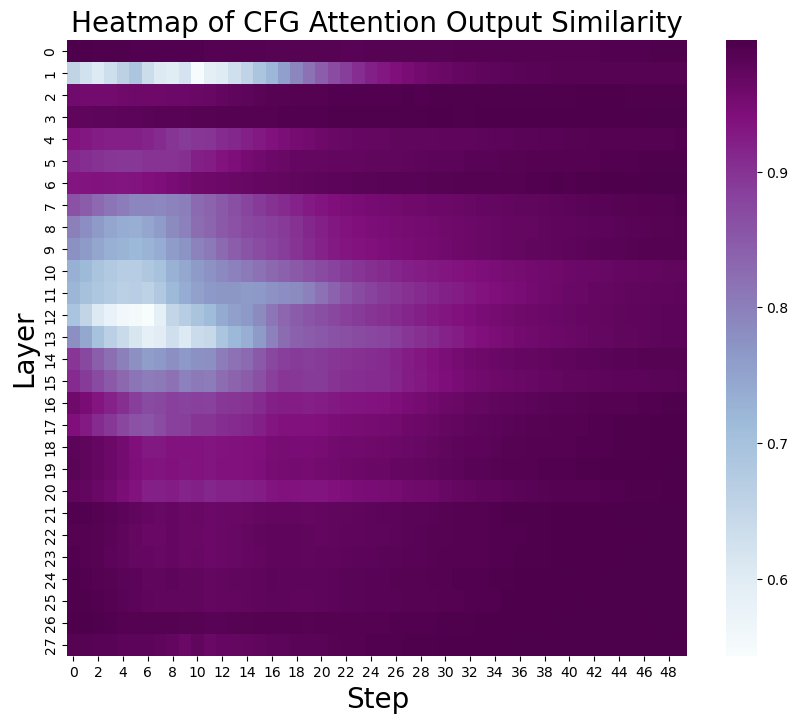

In [7]:
cos_hiddenlist_cfg = []
for layer_i in range(28):
    cos_hiddenlist_cfg.append([])
    for i in range(50):
        # cos_hiddenlist_cfg[-1].append([])
        cos_hiddenlist_cfg[-1].append(hidden_states_dict[f'block{layer_i}'][i])
        # cos_hiddenlist_cfg[-1][-1].append(hidden_states_dict[f'block{layer_i}'][i][1].reshape(-1))
# cos_hiddenlist_cfg = torch.tensor(cos_hiddenlist_cfg)
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'  # Calibri is a sans-serif font
plt.rcParams['font.sans-serif'] = ['Calibri'] + plt.rcParams['font.sans-serif']

# 计算每个格子的两个 tensor 的相似度
def cosine_similarity(tensor1, tensor2):
    tensor1 = torch.tensor(tensor1)
    tensor2 = torch.tensor(tensor2)
    return torch.nn.functional.cosine_similarity(tensor1, tensor2, dim=0).item()

similarity_matrix = np.zeros((28, 50))

for i in range(28):
    for j in range(50):
        tensor1 = cos_hiddenlist_cfg[i][j][:1].reshape(-1)
        tensor2 = cos_hiddenlist_cfg[i][j][1:].reshape(-1)
        similarity_matrix[i, j] = cosine_similarity(tensor1, tensor2)

# 绘制 heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False,cmap='BuPu' )#cmap='coolwarm'
plt.title('Heatmap of CFG Attention Output Similarity',fontsize=20)
plt.xlabel('Step',fontsize=20)
plt.ylabel('Layer',fontsize=20)
# plt.savefig(f'./DiTFastAttention/hidden_cosine_similarity_cfg.png', dpi=1000, bbox_inches='tight')
plt.show()
